In [ ]:
#исследование на наличие разрыва между требованиями работодателей и навыками, получаемыми студентами в вузах

In [1]:
import requests
import csv
import pandas as pd
import time
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import spacy
from spacy import load
from spacy.lang.ru.examples import sentences
from spacy.lang.ru import Russian
from pymorphy3 import MorphAnalyzer
from gensim.models.phrases import Phrases, Phraser
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import FastText
from matplotlib.lines import Line2D

In [2]:
#парсинг вакансий  с высшим образованим и без
import csv
import re
import time 
import pandas as pd
import requests

def get_vacancies(query="графический дизайн", area=1, total_vacancies=500, per_page=100):
    url = "https://api.hh.ru/vacancies"
    headers = {"User-Agent": "Mozilla/5.0"}
    
    responsibilities_higher = [] 
    responsibilities_no_higher = [] 
    higher_count = 0  
    no_higher_count = 0 
    pages = total_vacancies // per_page  

    higher_education_patterns = [
        r"высшее\s+образование",
        r"higher\s+education",
        r"в/о",
        r"ВО\s+обязательно",
        r"университетское\s+образование",
        r"бакалавр|магистр"
    ]

    for page in range(pages):
        params = {
            "text": query,
            "area": area,
            "per_page": per_page,
            "page": page,  
            "order_by": "publication_time"  
        }
        response = requests.get(url, params=params, headers=headers)

        if response.status_code == 200:
            data = response.json()
            if not data.get("items"): 
                break

            for item in data["items"]:
                requirements = item.get("snippet", {}).get("requirement", "") or ""
                responsibilities = item.get("snippet", {}).get("responsibility", "") or ""
                requirements_lower = requirements.lower()

                has_higher_education = any(
                    re.search(pattern, requirements_lower) 
                    for pattern in higher_education_patterns
                )

                tasks = re.split(r"[.;]", responsibilities)
                tasks = [task.strip() for task in tasks if task.strip()]

                if has_higher_education:
                    higher_count += 1
                    responsibilities_higher.extend(tasks)
                else:
                    no_higher_count += 1
                    responsibilities_no_higher.extend(tasks)

            time.sleep(1)  
        else:
            print(f" Ошибка запроса API: {response.status_code}")
            break  

    print(f"Вакансий с обязательным высшим образованием: {higher_count}")
    print(f"Вакансий без обязательного высшего образования: {no_higher_count}")
    print(f"Всего вакансий обработано: {higher_count + no_higher_count}")

    return responsibilities_higher, responsibilities_no_higher


def save_to_csv(responsibilities, filename):
    with open(filename, mode="w", newline="", encoding="utf-8-sig") as file:
        writer = csv.writer(file)
        for task in responsibilities:
            writer.writerow([task])
    print(f"Данные сохранены в {filename}")


if __name__ == "__main__":
    responsibilities_higher, responsibilities_no_higher = get_vacancies()
    save_to_csv(responsibilities_higher, "vacancies_higher.csv")
    save_to_csv(responsibilities_no_higher, "vacancies_no_higher.csv")

Вакансий с обязательным высшим образованием: 29
Вакансий без обязательного высшего образования: 471
Всего вакансий обработано: 500
Данные сохранены в vacancies_higher.csv
Данные сохранены в vacancies_no_higher.csv


In [3]:
comp = pd.read_excel('comp.xlsx')#файл с учебными планами по направлению графический диазйн со 4х вузов(РГСУ,РАНХиГС,МИСИС,НИУ ВШЭ)
vac_higher = pd.read_csv("vacancies_higher.csv")#вакансии с высшим
vac_no_higher = pd.read_csv("vacancies_no_higher.csv")#вакансии без высшего образования(ВО)
courses = pd.read_excel('Courses.xlsx')#курсы графического дизайна 

In [4]:
#очистка данных
load_model = load("ru_core_news_sm")
stopwords_ru = stopwords.words("russian")
stopwords_ru.extend(['<highlighttext>', 'highlighttext'])

def lemmatize_sentence(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', ' ', text)
    text = re.sub(r' +', ' ',text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords_ru]
    doc = load_model(' '.join(tokens))
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

comp["clean_text"] = comp['compet'].apply(lemmatize_sentence)
vac_higher["clean_text"] = vac_higher[vac_higher.columns[0]].apply(lemmatize_sentence)
vac_no_higher["clean_text"]=vac_no_higher[vac_no_higher.columns[0]].apply(lemmatize_sentence)
courses = [lemmatize_sentence(text) for text in courses['compet'].tolist()]

all_vac = vac_higher["clean_text"].tolist() + vac_no_higher["clean_text"].tolist()

In [12]:
#обучение модели через би и триграммы на всех собранных данных
from gensim.models.phrases import Phrases, Phraser

all = all_vac + courses + comp["clean_text"].tolist()

bigram_model = Phrases(all, min_count=2, threshold=10)
trigram_model = Phrases(bigram_model[all], threshold=10)

phraser_bigram = Phraser(bigram_model)
phraser_trigram = Phraser(trigram_model)

new_all = phraser_trigram[phraser_bigram[all]]

cleaned_and_phrasedALL = [" ".join(sentence).replace("_", " ") for sentence in new_all]
modelALL = FastText(sentences=new_all, vector_size=100, window=5, min_count=2, workers=4)

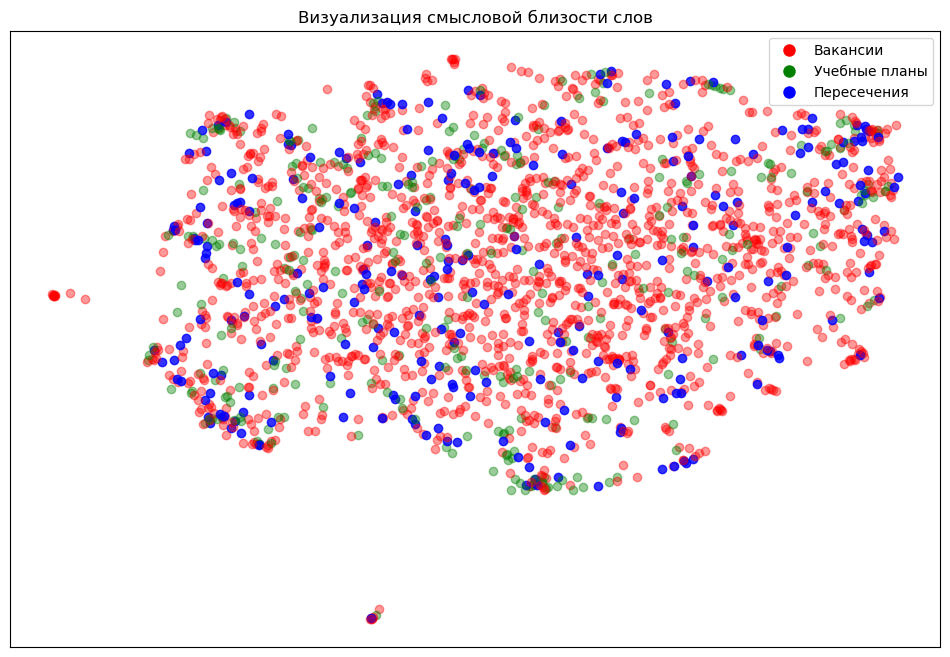

In [13]:
#визуализация смысловой близости слов между всеми вакансиями и учебными планами
#красные точки - только вакансии
#зеленые точки - только учебные планы
#синие - пересечения между вакансиями и учебными планами
import umap.umap_ as umap

import numpy as np
import matplotlib.pyplot as plt
from gensim.models import FastText
from matplotlib.lines import Line2D

unique_vacancies = {word for sent in all_vac for word in sent.split()}
unique_curriculum = {word for sentence in comp["clean_text"].tolist() for word in sentence.split()}

only_vacancies = unique_vacancies - unique_curriculum
only_curriculum = unique_curriculum - unique_vacancies
common_words = unique_vacancies & unique_curriculum

all_words = list((only_vacancies | only_curriculum | common_words))#если я уберу пересечение с мн-вом?

color_map = {word: "red" if word in only_vacancies else "green" if word in only_curriculum else "blue" for word in all_words}

vectors = np.array([modelALL.wv[word] for word in all_words])

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
word_vectors_2d = reducer.fit_transform(vectors)

plt.figure(figsize=(12, 8))

alpha_values = {
    "red": 0.4,    
    "green": 0.4,   
    "blue": 0.8     
}

for word, (x, y) in zip(all_words, word_vectors_2d):
    plt.scatter(x, y, color=color_map[word], alpha=alpha_values[color_map[word]])

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Вакансии'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Учебные планы'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Пересечения')
]

plt.legend(handles=legend_elements, loc='upper right')
plt.title("Визуализация смысловой близости слов")
plt.xticks([]) 
plt.yticks([]) 
plt.show()

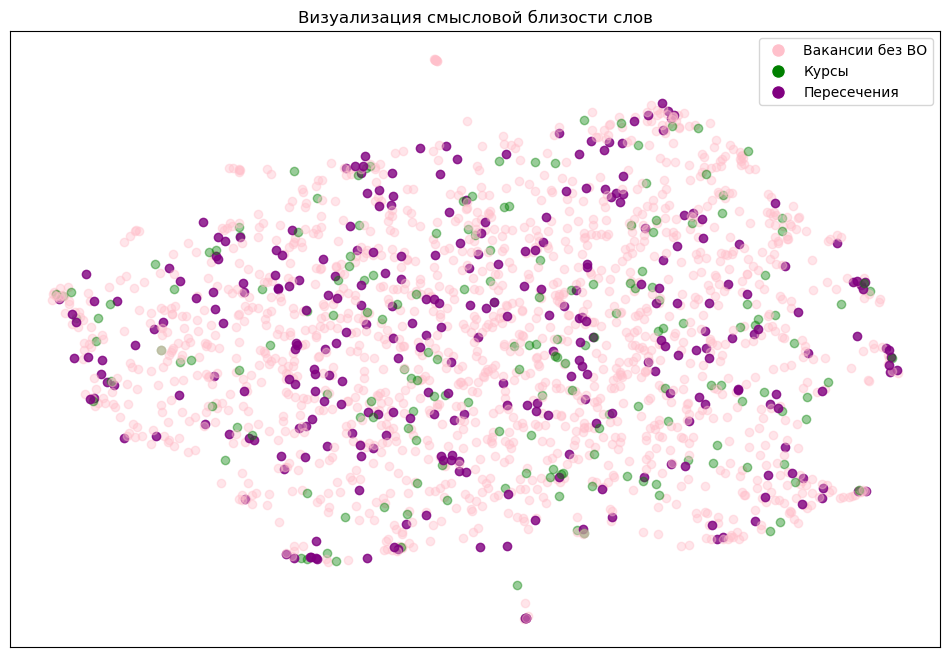

In [21]:
#смысловая близость слов вакансий без ВО и курсов
#розовые точки - вакансии без во
#зеленые точки - курсы
#синие - пересечения между вакансиями и курсами
import umap.umap_ as umap

import numpy as np
import matplotlib.pyplot as plt
from gensim.models import FastText
from matplotlib.lines import Line2D

unique_vacancies = {word for sent in vac_no_higher["clean_text"].tolist() for word in sent.split()}
unique_curriculum = {word for sentence in courses for word in sentence.split()}

only_vacancies = unique_vacancies - unique_curriculum
only_curriculum = unique_curriculum - unique_vacancies
common_words = unique_vacancies & unique_curriculum
all_words = list((only_vacancies | only_curriculum | common_words))

color_map = {word: "pink" if word in only_vacancies else "green" if word in only_curriculum else "purple" for word in all_words}

vectors = np.array([modelALL.wv[word] for word in all_words])

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
word_vectors_2d = reducer.fit_transform(vectors)

plt.figure(figsize=(12, 8))

alpha_values = {
    "pink": 0.4,    
    "green": 0.4,   
    "purple": 0.8     
}

for word, (x, y) in zip(all_words, word_vectors_2d):
    plt.scatter(x, y, color=color_map[word], alpha=alpha_values[color_map[word]])

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=10, label='Вакансии без ВО'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Курсы'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Пересечения')
]

plt.legend(handles=legend_elements, loc='upper right')
plt.title("Визуализация смысловой близости слов")
plt.xticks([]) 
plt.yticks([]) 
plt.show()

In [23]:
def get_average_vector(phrase,model): #функция для поиска среднего вектора предложения
    tokens = phrase.split()
    vectors = [] 
    for token in tokens: 
        vectors.append(model.wv[token])
    return np.mean(vectors, axis=0) 


def seek(query_phrase,model,array):#функция для поиска наиболее близкого по смыслу предложения(фразы) к заданному
    query_vector = get_average_vector(query_phrase,model)
    
    similarities = {}
    for doc in array: 
        doc_vector = get_average_vector(doc,model) 
        similarity = np.dot(query_vector, doc_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(doc_vector)) 
        similarities[doc] = similarity 
    
    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    return [sorted_similarities[0][0],sorted_similarities[0][1]]

In [25]:
#СРЕДНЕЕ СОВПАДЕНИЕ ВСЕХ ВАКАНСИЙ И УЧЕБНЫХ ПЛАНОВ (насколько учебные планы закрывают требования работодателей)
all_c=[]
count=0
comp = pd.read_excel('comp.xlsx')
comp["clean_text"] = comp['compet'].apply(lemmatize_sentence)
comp = [text for text in comp["clean_text"]]
comp = list(set(comp))
comp = [text for text in comp if text!='']

all_vac = list(set(all_vac))
all_vac = [text for text in all_vac if text!='']
for word in all_vac:
    similar = seek(word,modelALL,comp)
    all_c.append([similar[0],similar[1],word])
    count+=(similar[1])
all_c = sorted(all_c, key = lambda item: item[1], reverse = True)
print(count/len(all_c))

0.4219181562654974


In [26]:
#СРЕДНЕЕ СОВПАДЕНИЕ ВАКАНСИЙ БЕЗ ВО И КУРСОВ (насколько курсы закрывают требования работодателей)
all_c=[]
count=0

courses = list(set(courses))
courses = [text for text in courses if text!='']

vac_no_higher = pd.read_csv("vacancies_no_higher.csv")
vac_no_higher["clean_text"]=vac_no_higher[vac_no_higher.columns[0]].apply(lemmatize_sentence)
vac_no_higher = vac_no_higher["clean_text"].tolist()
vac_no_higher = list(set(vac_no_higher))
vac_no_higher = [text for text in vac_no_higher if text!='']
for word in vac_no_higher:
    similar = seek(word,modelALL,courses)
    all_c.append([similar[0],similar[1],word])
    count+=(similar[1])
all_c = sorted(all_c, key = lambda item: item[1], reverse = True)
print(count/len(all_c))

0.48804677854752715


In [27]:
#ВУЗЫ
rgsu = pd.read_excel('rgsu.xlsx')
ranx = pd.read_excel('ranx.xlsx')
misis = pd.read_excel('misis.xlsx')
hse = pd.read_excel('hse.xlsx')

In [28]:
#ОЧИСТКА ДАННЫХ
load_model = load("ru_core_news_sm")
stopwords_ru = stopwords.words("russian")
stopwords_ru.extend(['<highlighttext>', 'highlighttext'])

def lemmatize_sentence(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', ' ', text)
    text = re.sub(r' +', ' ',text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords_ru]
    doc = load_model(' '.join(tokens))
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

rgsu["clean_text"] = rgsu[rgsu.columns[0]].apply(lemmatize_sentence)
ranx["clean_text"] = ranx[ranx.columns[0]].apply(lemmatize_sentence)
misis["clean_text"] = misis[misis.columns[0]].apply(lemmatize_sentence)
hse["clean_text"] = hse[hse.columns[0]].apply(lemmatize_sentence)

In [33]:
#поиск среднего совпадения учебных планов и требований для каждого вуза, чтобы найти вуз, программа которого актуальнее всего
RGSU=[]
RGSU_SR=0
count=0
for word in rgsu["clean_text"]:
    similar = seek(word,modelALL,all_vac)
    RGSU.append([word,similar[0],similar[1]])
    RGSU_SR+=similar[1]
    count+=1

In [34]:
RANX=[]
RANX_SR=0
count=0
for word in ranx["clean_text"]:
    similar = seek(word,modelALL,all_vac)
    RANX.append([word,similar[0],similar[1]])
    RANX_SR+=similar[1]
    count+=1

In [35]:
MISIS=[]
MISIS_SR=0
count=0
for word in misis["clean_text"]:
    similar = seek(word,modelALL,all_vac)
    MISIS.append([word,similar[0],similar[1]])
    MISIS_SR+=similar[1]
    count+=1

In [36]:
HSE=[]
HSE_SR=0
count=0
for word in hse["clean_text"]:
    similar = seek(word,modelALL,all_vac)
    HSE.append([word,similar[0],similar[1]])
    HSE_SR+=similar[1]
    count+=1

In [37]:
#самая актуальная программа у МИСИС
print(f"РГСУ : {RGSU_SR/len(RGSU)}")
print(f"РАНХ : {RANX_SR/len(RANX)}")
print(f"МИСИС : {MISIS_SR/len(MISIS)}")
print(f"ВЫШКА : {HSE_SR/len(HSE)}")

РГСУ : 0.47264693591329787
РАНХ : 0.5147765059860385
МИСИС : 0.5265057889314798
ВЫШКА : 0.5144631763299307


In [38]:
vac_no_higher = pd.read_csv("vacancies_no_higher.csv")
vac_no_higher["clean_text"]=vac_no_higher[vac_no_higher.columns[0]].apply(lemmatize_sentence)
vac_no_higher = vac_no_higher["clean_text"].tolist()
vac_no_higher = list(set(vac_no_higher))
vac_no_higher = [text for text in vac_no_higher if text!='']

In [39]:
courses = pd.read_excel('Courses.xlsx')

In [40]:
#КУРСЫ
yand = courses[courses['course'] =='Яндекс']['compet'].tolist()
netology = courses[courses['course'] =='netology']['compet'].tolist()
contented = courses[courses['course'] =='contented']['compet'].tolist()
skillbox = courses[courses['course'] =='skillbox']['compet'].tolist()

In [41]:
courses = [lemmatize_sentence(text) for text in courses['compet'].tolist()]
courses = list(set(courses))
courses = [text for text in courses if text!='']

In [42]:
#ОЧИСТКА
load_model = load("ru_core_news_sm")
stopwords_ru = stopwords.words("russian")
stopwords_ru.extend(['<highlighttext>', 'highlighttext'])

def lemmatize_sentence(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', ' ', text)
    text = re.sub(r' +', ' ',text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords_ru]
    doc = load_model(' '.join(tokens))
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

yand = [lemmatize_sentence(text) for text in yand]
netology = [lemmatize_sentence(text) for text in netology]
contented = [lemmatize_sentence(text) for text in contented]
skillbox = [lemmatize_sentence(text) for text in skillbox]

In [43]:
#поиск среднего совпадения курсов и требований для каждого курса, чтобы найти курс, программа которого актуальнее всего
YAND=[]
YAND_SR=0
for word in yand:
    similar = seek(word,modelALL,vac_no_higher)
    YAND.append([word,similar[0],similar[1]])
    YAND_SR+=similar[1]


In [44]:
NETOLOGY=[]
NETOLOGY_SR=0
count=0
for word in netology:
    similar = seek(word,modelALL,vac_no_higher)
    NETOLOGY.append([word,similar[0],similar[1]])
    NETOLOGY_SR+=similar[1]
    count+=1

In [45]:
CONT=[]
CONT_SR=0
count=0
for word in contented:
    similar = seek(word,modelALL,vac_no_higher)
    CONT.append([word,similar[0],similar[1]])
    CONT_SR+=similar[1]
    count+=1

In [46]:
SKILL=[]
SKILL_SR=0
count=0
for word in skillbox:
    similar = seek(word,modelALL,vac_no_higher)
    SKILL.append([word,similar[0],similar[1]])
    SKILL_SR+=similar[1]
    count+=1

In [47]:
#лучшим оказался курс от яндекс практикума
print(f"ЯНДЕКС : {YAND_SR/len(YAND)}")
print(f"СКИЛЛБОКС : {NETOLOGY_SR/len(NETOLOGY)}")
print(f"НЕТОЛОГИЯ : {CONT_SR/len(CONT)}")
print(f"CONTENTED: {SKILL_SR/len(SKILL)}")

ЯНДЕКС : 0.5734830110856931
СКИЛЛБОКС : 0.5421417667603617
НЕТОЛОГИЯ : 0.5446428003219458
CONTENTED: 0.5530465881932866


In [ ]:
# по итогам исследования, можно отметить, что разрыв между навыками и знаниями, которые дает вуз, очень большой,
# однако его невозможно закрыть одними курсами, так как курсы, также как и вузы закрывают требования работодателей не более чем на 50%